In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import optuna
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\gianm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def load_data():    
    data = pd.read_csv('dataset.csv')
    X = data.drop('income', axis=1)
    y = data['income']
    return X, y

In [4]:
def build_model(trial, input_dim):
    model = Sequential()
    n_layers = trial.suggest_int("n_layers", 1, 5)

    # First Layer
    units = trial.suggest_int(f"n_units_i", 16, 256, step=16)
    model.add(Dense(units, activation="relu", input_dim=input_dim))  # input_dim specified
    dropout_rate = trial.suggest_float(f"dropout_rate", 0.0, 0.5)
    model.add(Dropout(dropout_rate))

    # Hidden Layers
    units_h = trial.suggest_int(f"n_units_h", 16, 256, step=16) 
    for i in range(n_layers):
        model.add(Dense(units_h, activation="relu"))
        model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(1, activation="sigmoid"))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=trial.suggest_float("lr", 1e-4, 1e-2, log=True)),
                  loss="binary_crossentropy",
                  metrics=["accuracy"])
    return model


In [5]:
def objective(trial):
    X, y = load_data()
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    accuracies = []

    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        model = build_model(trial, input_dim=X_train.shape[1])
        model.fit(X_train, y_train, epochs=10, batch_size=128, verbose=0)
        y_pred = (model.predict(X_test) > 0.5).astype(int)
        accuracies.append(accuracy_score(y_test, y_pred))
    
    return np.mean(accuracies)

In [5]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

print("Best hyperparameters:", study.best_params)

[I 2025-01-12 11:06:49,594] A new study created in memory with name: no-name-0a36ba6b-2878-40d1-a704-f3108c7b89f5


306/306 [==============================] - 0s 549us/step


[I 2025-01-12 11:07:23,979] Trial 0 finished with value: 0.8347324024440412 and parameters: {'n_layers': 3, 'n_units_i': 208, 'dropout_rate': 0.3475328770872465, 'n_units_h': 64, 'lr': 0.0001824341593239537}. Best is trial 0 with value: 0.8347324024440412.


306/306 [==============================] - 0s 512us/step


[I 2025-01-12 11:07:49,719] Trial 1 finished with value: 0.8348552001689479 and parameters: {'n_layers': 1, 'n_units_i': 112, 'dropout_rate': 0.10726012989499595, 'n_units_h': 80, 'lr': 0.0004255020679933103}. Best is trial 1 with value: 0.8348552001689479.


306/306 [==============================] - 0s 590us/step


[I 2025-01-12 11:08:49,222] Trial 2 finished with value: 0.8344253064797644 and parameters: {'n_layers': 5, 'n_units_i': 32, 'dropout_rate': 0.24676261930136822, 'n_units_h': 112, 'lr': 0.0028340948635196543}. Best is trial 1 with value: 0.8348552001689479.


306/306 [==============================] - 0s 561us/step


[I 2025-01-12 11:09:28,264] Trial 3 finished with value: 0.835407994283007 and parameters: {'n_layers': 5, 'n_units_i': 112, 'dropout_rate': 0.1338023698867452, 'n_units_h': 48, 'lr': 0.0003691616696359053}. Best is trial 3 with value: 0.835407994283007.


306/306 [==============================] - 0s 818us/step


[I 2025-01-12 11:10:30,441] Trial 4 finished with value: 0.8348142270729024 and parameters: {'n_layers': 4, 'n_units_i': 112, 'dropout_rate': 0.45861658573074815, 'n_units_h': 208, 'lr': 0.0008623035436797251}. Best is trial 3 with value: 0.835407994283007.


306/306 [==============================] - 0s 538us/step


[I 2025-01-12 11:10:48,449] Trial 5 finished with value: 0.8340157809192512 and parameters: {'n_layers': 1, 'n_units_i': 128, 'dropout_rate': 0.15874265494998147, 'n_units_h': 16, 'lr': 0.009744754921011194}. Best is trial 3 with value: 0.835407994283007.


306/306 [==============================] - 0s 707us/step


[I 2025-01-12 11:11:48,020] Trial 6 finished with value: 0.8293681881101268 and parameters: {'n_layers': 3, 'n_units_i': 208, 'dropout_rate': 0.4891067297002029, 'n_units_h': 256, 'lr': 0.007279548337825555}. Best is trial 3 with value: 0.835407994283007.


306/306 [==============================] - 0s 549us/step


[I 2025-01-12 11:12:12,128] Trial 7 finished with value: 0.8354694738382935 and parameters: {'n_layers': 1, 'n_units_i': 64, 'dropout_rate': 0.1896961902748603, 'n_units_h': 96, 'lr': 0.002924592545786669}. Best is trial 7 with value: 0.8354694738382935.


306/306 [==============================] - 0s 623us/step


[I 2025-01-12 11:13:03,413] Trial 8 finished with value: 0.8346504604437863 and parameters: {'n_layers': 4, 'n_units_i': 224, 'dropout_rate': 0.3299773325125916, 'n_units_h': 96, 'lr': 0.000519853474887041}. Best is trial 7 with value: 0.8354694738382935.


306/306 [==============================] - 0s 595us/step


[I 2025-01-12 11:13:46,434] Trial 9 finished with value: 0.8347323919644525 and parameters: {'n_layers': 4, 'n_units_i': 160, 'dropout_rate': 0.34652349894269024, 'n_units_h': 128, 'lr': 0.000455453138039812}. Best is trial 7 with value: 0.8354694738382935.


306/306 [==============================] - 0s 623us/step


[I 2025-01-12 11:14:15,861] Trial 10 finished with value: 0.8348961502098977 and parameters: {'n_layers': 2, 'n_units_i': 16, 'dropout_rate': 0.020339910520368376, 'n_units_h': 176, 'lr': 0.0021090369379438948}. Best is trial 7 with value: 0.8354694738382935.


306/306 [==============================] - 0s 571us/step


[I 2025-01-12 11:14:42,483] Trial 11 finished with value: 0.8317840581813352 and parameters: {'n_layers': 5, 'n_units_i': 64, 'dropout_rate': 0.16779065994686176, 'n_units_h': 16, 'lr': 0.003285623420812665}. Best is trial 7 with value: 0.8354694738382935.


306/306 [==============================] - 0s 557us/step


[I 2025-01-12 11:15:07,819] Trial 12 finished with value: 0.832869230074676 and parameters: {'n_layers': 2, 'n_units_i': 64, 'dropout_rate': 0.04914199195596283, 'n_units_h': 48, 'lr': 0.000112158256535689}. Best is trial 7 with value: 0.8354694738382935.


306/306 [==============================] - 0s 557us/step


[I 2025-01-12 11:15:40,757] Trial 13 finished with value: 0.8361041282118158 and parameters: {'n_layers': 2, 'n_units_i': 80, 'dropout_rate': 0.2215863967530906, 'n_units_h': 160, 'lr': 0.0013720677874729718}. Best is trial 13 with value: 0.8361041282118158.


306/306 [==============================] - 0s 589us/step


[I 2025-01-12 11:16:13,012] Trial 14 finished with value: 0.8362269594714062 and parameters: {'n_layers': 2, 'n_units_i': 64, 'dropout_rate': 0.2435176042315698, 'n_units_h': 160, 'lr': 0.0016103564312612431}. Best is trial 14 with value: 0.8362269594714062.


306/306 [==============================] - 0s 559us/step


[I 2025-01-12 11:16:49,040] Trial 15 finished with value: 0.8352237086191432 and parameters: {'n_layers': 2, 'n_units_i': 160, 'dropout_rate': 0.2547555807826318, 'n_units_h': 160, 'lr': 0.0013527414167508142}. Best is trial 14 with value: 0.8362269594714062.


306/306 [==============================] - 0s 794us/step


[I 2025-01-12 11:17:25,790] Trial 16 finished with value: 0.8357765656107349 and parameters: {'n_layers': 2, 'n_units_i': 80, 'dropout_rate': 0.24884843014427643, 'n_units_h': 208, 'lr': 0.0011068684857845285}. Best is trial 14 with value: 0.8362269594714062.


306/306 [==============================] - 0s 631us/step


[I 2025-01-12 11:18:12,436] Trial 17 finished with value: 0.8311288491424638 and parameters: {'n_layers': 3, 'n_units_i': 256, 'dropout_rate': 0.41240971769302726, 'n_units_h': 160, 'lr': 0.005021943021880043}. Best is trial 14 with value: 0.8362269594714062.


306/306 [==============================] - 0s 600us/step


In [6]:
import optuna.visualization as vis
fig = vis.plot_optimization_history(study)
fig.show()

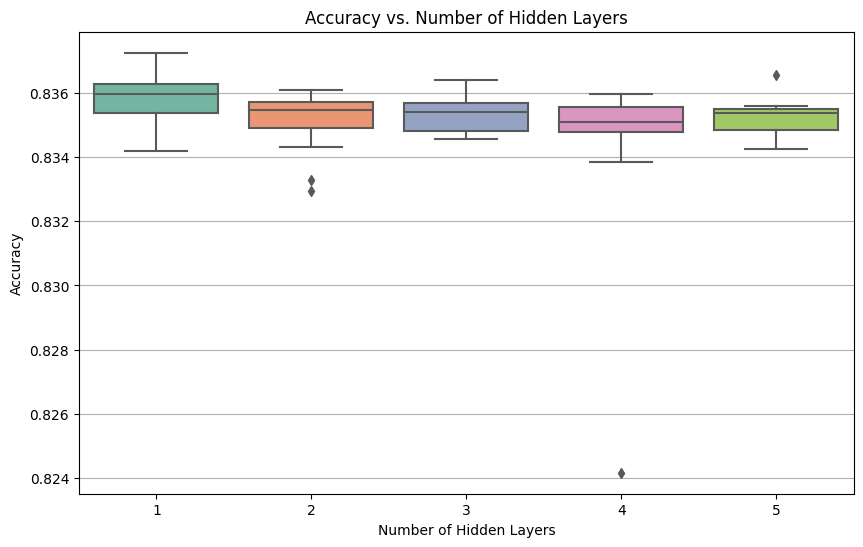

In [7]:


n_layers = [trial.params['n_layers'] for trial in study.trials]
accuracies = [trial.value for trial in study.trials]


data = pd.DataFrame({'n_layers': n_layers, 'accuracy': accuracies})
plt.figure(figsize=(10, 6))
sns.boxplot(x='n_layers', y='accuracy', data=data, palette='Set2')


plt.title('Accuracy vs. Number of Hidden Layers')
plt.xlabel('Number of Hidden Layers')
plt.ylabel('Accuracy')
plt.grid(axis='y') 
plt.show()

In [ ]:
n_units_i = [trial.params['n_units_i'] for trial in study.trials]
n_units_h = [trial.params['n_units_h'] for trial in study.trials]
accuracies = [trial.value for trial in study.trials if trial.value is not None]

data = pd.DataFrame({'n_units_i': n_units_i, 'n_units_h': n_units_h, 'accuracy': accuracies})

pivot_data = data.pivot_table(index='n_units_h', columns='n_units_i', values='accuracy')

plt.figure(figsize=(12, 8))
for n_input_neurons in pivot_data.columns:
    plt.plot(pivot_data.index, pivot_data[n_input_neurons], marker='o', label=f'n_units_i={n_input_neurons}')

# Customize the plot
plt.title('Accuracy vs. Number of Neurons (Input and Hidden Layers)', fontsize=14)
plt.xlabel('Number of Neurons in Hidden Layer ', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(title='Input Layer Neurons', fontsize=10)
plt.grid(alpha=0.3)
plt.xticks(pivot_data.index) 
plt.show()

NameError: name 'study' is not defined

In [8]:
def build_best_model(study, input_dim):
    model = Sequential()
    X, _ = load_data()
    model = Sequential()
    n_layers = study.best_params['n_layers']

    # Input Layer
    units = study.best_params['n_units_i']
    model.add(Dense(units, activation="relu", input_dim=input_dim))  # input_dim specified
    dropout_rate = study.best_params['dropout_rate']
    model.add(Dropout(dropout_rate))

    # Hidden Layers
    units_h = study.best_params['n_units_h']
    for i in range(n_layers):
        model.add(Dense(units_h, activation="relu"))
        model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(1, activation="sigmoid"))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=study.best_params['lr']),
                  loss="binary_crossentropy",
                  metrics=["accuracy"])
    return model

In [9]:
X, y = load_data()
scaler = StandardScaler()
X = scaler.fit_transform(X)
    
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_idx, test_idx in skf.split(X, y):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    model = build_best_model(study, X_train.shape[1])
    model.fit(X_train, y_train, epochs=10, batch_size=128, verbose=0)
    y_pred = (model.predict(X_test) > 0.5).astype(int)


print(accuracy_score(y_test, y_pred))
joblib.dump(model, 'ann_model.joblib')

306/306 [==============================] - 0s 1ms/step
0.8322072072072072
Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\dense_2
......vars
.........0
.........1
...layers\dropout
......vars
...layers\dropout_1
......vars
...metrics\mean
......vars
.........0
.........1
...metrics\mean_metric_wrapper
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........2
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:
File Name                                             Modified             Size
config.json                                    2025-01-11 21:24:28         2594
metadata.json                                  2025-01-11 21:24:28           64
variables.h5                                   2025-01-11 21:24:29       650688


['ann_model.joblib']